# Artificial neural network for Water Distribution Systems Metamodelling - Machine learning project (1/2)

**Objectives:**
- Implement an artificial neural network (ANN) to metamodel a water distribution system.

**Completition requirements:**

By the end of this notebook, you should have:
- Implemented all the code cells for:
  - Loading the dataset of simulations
  - Defining an ANN
  - Training the ANN
  - Testing the performance of the ANN
  - Saving the metamodel for later use
- Answered all the questions

## 📔 Libraries

<!-- 
# If you have not installed pytorch geometric uncomment the following lines to install it

# !pip install -q torch-scatter -f https://data.pyg.org/whl/torch-${TORCH}.html
# !pip install -q torch-sparse -f https://data.pyg.org/whl/torch-${TORCH}.html
# !pip install -q git+https://github.com/pyg-team/pytorch_geometric.git

# !pip install wntr -->

To run this notebook you need to have installed the following packages:
- Pandas
- Numpy
- Matplotlib
- Pickle
- WNTR
- Scikit-learn

In [23]:
import time
import pickle
import numpy as np
import matplotlib.pyplot as plt
import wntr

from sklearn.neural_network import MLPRegressor
from sklearn.preprocessing import StandardScaler, MinMaxScaler

## 🔙 Background

### 💧 Water distribution systems

Water utilities rely on hydrodynamic models to properly design and control water distribution systems (WDSs). These physically-based models, such as [EPANET](https://www.epa.gov/water-research/epanet), compute the state of the system, i.e., the flow rates and pressures at all the pipes and junctions, as illustrated in Figure 1. 

Hydrodynamic models provide valuable insight into the functioning of the system. However, the computational speed of these models is often insufficient for some applications in civil engineering such as optimisation of design or criticality assessment, especially in large search space problems. 

One alternative to address this issue is developing data-driven models. These models are trained using results calculated using the original model (EPANET, in this case) in multiple scenarios. The objective of the data-driven models is to estimate the output of the original model but in a shorter time.

<div>
<center><img src="./Images/Modena.png" width="700"/></center>
</div>

Figure 1. Numerical results for the water distribution system in the city of Modena, Italy.

Water modellers have resorted to metamodels to replace computationally costly models. Metamodels are a faster-to-run alternative.

## ⛔ Problem definition 

The problem is to create an alternative model of WNTR using an ANN, exemplified in Figure 2. The metamodel should give approximate solution while being faster to run. 

<div>
<center><img src="./Images/ANN_image.png" width="1000"/></center>
</div>


Figure 2. Artificial neural network representation.

## 🏋🏽‍♀️ Exercise: Metamodel

### Load the database of examples

Training

In [2]:
file_path = r"./Datasets/Modena/features_Modena_training.p"
with open(file_path, 'rb') as handle:
    training_features = pickle.load(handle)

file_path = r"./Datasets/Modena/targets_Modena_training.p"
with open(file_path, 'rb') as handle:
    training_targets = pickle.load(handle)

Validation

In [3]:
file_path = r"./Datasets/Modena/features_Modena_validation.p"
with open(file_path, 'rb') as handle:
    validation_features = pickle.load(handle)

file_path = r"./Datasets/Modena/targets_Modena_validation.p"
with open(file_path, 'rb') as handle:
    validation_targets = pickle.load(handle)

### Data pre-processing

In [4]:
max_feature = 1 #training_features.max()
min_feature = 0 #training_features.min()

max_target = training_targets.max()
min_target = training_targets.min()


def min_max_normalize(data, min, max):
    return (data-min)/(max-min)

def inverse_min_max_normalize(data, min, max):
    return (data)*(max-min)+min

In [5]:
X_train = min_max_normalize(training_features, min_feature, max_feature)
y_train = min_max_normalize(training_targets, min_target, max_target)

X_val = min_max_normalize(validation_features, min_feature, max_feature)
y_val = min_max_normalize(validation_targets, min_target, max_target)

### Define the metamodel

#### Linear Model

First, let's try a linear model with linear features. We use the `MLPRegressor` to stay consistent with the workflow for the rest of the notebook. A linear model with linear features can be obtained by setting the activation function to be the identity. The inputs are multiplied with the weights twice &mdash; once before and once after the hidden layer. However, the linear combination of linear models will still result in a linear model, which makes this little trick work. The training is trivial, and we therefore employ the built-in `MLPRegressor.fit()` function to this end.

In [6]:
# Set up linear regression model
linear_model = MLPRegressor(solver='sgd', 
                            hidden_layer_sizes=(10), 
                            activation='identity', 
                            learning_rate='constant',
                            # verbose = True
                            )

# train NN
linear_model.fit(X_train, y_train)
# Make predictions
y_pred = linear_model.predict(X_val)

In [7]:
y_pred.shape

(1000, 272)

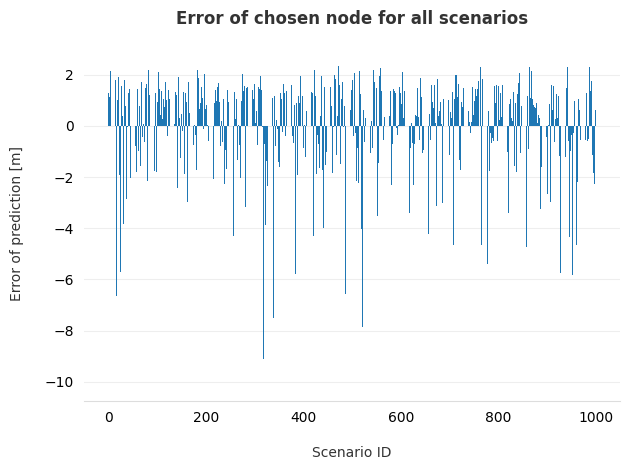

In [25]:
error = inverse_min_max_normalize(y_val, min_target, max_target) - inverse_min_max_normalize(y_pred, min_target, max_target)
error_node = error[:,0]

fig, ax = plt.subplots()

bars = ax.bar(
    x=np.arange(error_node.size),
    height=error_node,
)

# Axis formatting.
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['left'].set_visible(False)
ax.spines['bottom'].set_color('#DDDDDD')
ax.tick_params(bottom=False, left=False)
ax.set_axisbelow(True)
ax.yaxis.grid(True, color='#EEEEEE')
ax.xaxis.grid(False)

ax.set_xlabel('Scenario ID', labelpad=15, color='#333333')
ax.set_ylabel('Error of prediction [m]', labelpad=15, color='#333333')
ax.set_title(f'Error of chosen node for all scenarios', pad=15, color='#333333', weight='bold')

fig.tight_layout()

This is not awful, but we can do better than that. Now, let's try a nonlinear model. As you might already have guessed from the implementation of the linear model, we propose a neural network. We also discard the `MPLRegressor.fit()` function and implement the training loop our selves, to be able to take a look under the hood.

#### Artificial Neural Network

With our dataset ready, we can create a function to train a neural network (NN). There are many choices to be made when creating such a function, most are related to the bias - variance tradeoff discussed in the lectures. The outline of the function we want to create is as follows:

`def NN_train()`:<br>
&emsp;&emsp; For a maximum number of epochs:<br>
&emsp;&emsp;&emsp;&emsp; Permutate the data<br> 
&emsp;&emsp;&emsp;&emsp; For every minibatch:<br> 
&emsp;&emsp;&emsp;&emsp;&emsp;&emsp; Collect the X & y training data<br> 
&emsp;&emsp;&emsp;&emsp;&emsp;&emsp; Take a NN step (partial fit)<br> 
&emsp;&emsp;&emsp;&emsp; Compute the root mean squared error (RMSE) on the validation set<br> 
&emsp;&emsp;&emsp;&emsp; If the RMSE is the lowest:<br> 
&emsp;&emsp;&emsp;&emsp;&emsp;&emsp; Save the RMSE & NN model<br> 
&emsp;&emsp;&emsp;&emsp; If RMSE has not decreased in the last X epochs<br> 
&emsp;&emsp;&emsp;&emsp;&emsp;&emsp; Stop the training loop<br> 
&emsp;&emsp;&emsp;&emsp; Adapt the learning rate if necessary<br> 
&emsp;&emsp; Return NN, rmse_min & full_rmse_array<br>



In [9]:
# Function to train the NN
def NN_train(NN, X_train, y_train, X_val, y_val, 
             max_epoch=100, 
             tol=1e-6, 
             verbose=False, 
             lr_init=0.001, 
             lr_pow=0.9, 
             lr_step=500, 
             seed=0, 
             batchsize=50):
    
    # Set seed 
    np.random.seed(seed)
    
    # Set up array for mse and improvement count for early stopping
    rmse = [] 
    rmse_min = 1e10
    no_improvement_count = 0
    
    # Init learning rate
    lr = lr_init
    NN.learning_rate_init = lr
    
    NN_best = NN
    
    # Loop over iterations
    for epoch in range(max_epoch):
            
        # Set up permutation of the data
        n = X_train.shape[0]
        perm = np.random.permutation(n)
        batches_per_epoch = int(np.floor(n/batchsize))
        
        # Loop over batches
        for it in range(batches_per_epoch):
            
            # Collect current batch
            X_batch = X_train[perm[it*batchsize:(it+1)*batchsize]]
            y_batch = y_train[perm[it*batchsize:(it+1)*batchsize]]
                
            # Take step
            NN.partial_fit(X_batch, y_batch)
            
        # Compute rmse on validation set after each epoch
        y_val_hat = NN.predict(X_val)
        rmse.append(np.sqrt(np.sum((y_val - y_val_hat)**2)/len(y_val)))
        
        # Adapt learning rate
        if (epoch > 0) and (epoch%lr_step==0):
            lr *= lr_pow
            NN.learning_rate_init = lr
            if verbose:
                print("Reduced learning rate to {:.4e}".format(lr))
        
        # Check if no improvement occured in last iterations
        if rmse[-1] - rmse_min > tol:
            no_improvement_count += 1
        elif rmse[-1] < rmse_min:
            rmse_min = rmse[-1]
            no_improvement_count = 0
            NN_best = NN
        
        # Exit loop when no improvement was registered during past twenty iters
        if no_improvement_count == 20:
            print("Training stopped after {} epochs".format(epoch))
            break
        
        # Print loss (optional)
        if verbose and epoch%2==0:
            print("\nIteration {}".format(epoch))
            print("   rmse {:.4e}\n".format(rmse[epoch]))
    
    if (epoch==max_epoch-1): print("Reached max_epochs ( {} )".format(max_epoch))
    
    # Return trained network and last rmse
    return NN_best, rmse_min, rmse

In [10]:
# Set up NN
NN = MLPRegressor(solver='adam', 
                  hidden_layer_sizes=(128, 128, 128, 128), 
                  activation='relu',
                  batch_size = 32,
                  learning_rate='constant',
                  )

# train NN
NN, _, rmse = NN_train(NN, X_train, y_train, X_val, y_val, max_epoch=100, verbose=True, lr_init=1e-1, lr_step=50)


Iteration 0
   rmse 1.2737e+00


Iteration 2
   rmse 1.1024e+00


Iteration 4
   rmse 9.2316e-01


Iteration 6
   rmse 7.5506e-01


Iteration 8
   rmse 7.0416e-01


Iteration 10
   rmse 7.2670e-01


Iteration 12
   rmse 6.4810e-01


Iteration 14
   rmse 6.5817e-01


Iteration 16
   rmse 6.5456e-01


Iteration 18
   rmse 8.0361e-01


Iteration 20
   rmse 6.7200e-01


Iteration 22
   rmse 6.2518e-01


Iteration 24
   rmse 7.1881e-01


Iteration 26
   rmse 8.2839e-01


Iteration 28
   rmse 7.6922e-01


Iteration 30
   rmse 7.3414e-01


Iteration 32
   rmse 6.3003e-01


Iteration 34
   rmse 6.7810e-01


Iteration 36
   rmse 1.3986e+00


Iteration 38
   rmse 6.9230e-01


Iteration 40
   rmse 6.4243e-01

Training stopped after 42 epochs


You can use the following plotting routines to visualize your predictions. Keep in mind that all of the following graphs are based on projections of the input data on 1D or 2D subspaces that suppress at least part of the information contained in the dataset. Those projections, however, are necessary to enable visualizations of the predictions.

In [11]:
error[10,:].shape

(272,)

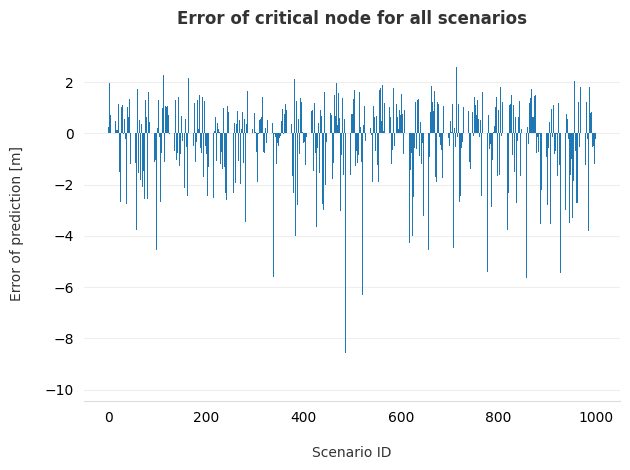

In [12]:
y_pred = NN.predict(X_val)

error = inverse_min_max_normalize(y_val, min_target, max_target) - inverse_min_max_normalize(y_pred, min_target, max_target)
error_node = error[:,10]

fig, ax = plt.subplots()

bars = ax.bar(
    x=np.arange(error_node.size),
    height=error_node,
)


# Axis formatting.
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['left'].set_visible(False)
ax.spines['bottom'].set_color('#DDDDDD')
ax.tick_params(bottom=False, left=False)
ax.set_axisbelow(True)
ax.yaxis.grid(True, color='#EEEEEE')
ax.xaxis.grid(False)

ax.set_xlabel('Scenario ID', labelpad=15, color='#333333')
ax.set_ylabel('Error of prediction [m]', labelpad=15, color='#333333')
ax.set_title(f'Error of critical node for all scenarios', pad=15, color='#333333', weight='bold')

fig.tight_layout()

## Hyperparameter tuning

We need to quantify the error and compare it for different architectures to find the best-performing model. For this purpose, we turn to a grid-search strategy to find hyperparameters that give the best prediction on a validation set.

Note: For the parameters, at least vary the number of layers and the size of each layer. Optionally, also look at the activation function.

In [13]:
# define coordinate vectors for grid
layer_sizes = [10] #,10, 15, 20
layer_numbers = [1] #1, 2, 3, 4

# get grid for the coordinate pairs and store them in an array
rmse = np.zeros((len(layer_sizes), len(layer_numbers)))

# loop all hidden layer sizes
for i, lsize in enumerate(layer_sizes):
    
    # loop over all numbers of hidden layers
    for j, lnumber in enumerate(layer_numbers):
    
        # get tuple for archbatch_size=cture and print
        layers = (lsize,) * lnumber
        print("Training NN with hidden layers:  {}".format(layers))
        
        # get NN
        NN = MLPRegressor(solver='adam', hidden_layer_sizes=layers, activation='relu')
        NN, rmse[i,j], _ = NN_train(NN, X_train, y_train, X_val, y_val, max_epoch=100000, verbose=False, lr_init=1e-1, lr_step=20)
        
        # print
        print("     Mean square error:    {:.4e}\n".format(rmse[i,j]))


# get NN that gave lowest rmse and print
min_size, min_number = np.unravel_index(np.argmin(rmse), rmse.shape)
print("\n\nModel with {} layers and {} neurons per layer gave lowest rmse of {:.4e}".format(layer_numbers[min_number], layer_sizes[min_size], rmse[min_size, min_number]))

Training NN with hidden layers:  (10,)
Training stopped after 27 epochs
     Mean square error:    4.4781e-01



Model with 1 layers and 10 neurons per layer gave lowest rmse of 4.4781e-01


Let's use our test data to visualize our best-performing model and test its predictive capabilities. First, re-initialize & train the model with the optimal hyperparameters.


In [14]:
# Set up NN
layers = (layer_sizes[min_size],) * layer_numbers[min_number]
NN = MLPRegressor(solver='sgd', hidden_layer_sizes=layers, activation='relu', batch_size = 32)

# train NN
NN, _, _ = NN_train(NN, X_train, y_train, X_val, y_val, max_epoch=100, verbose=True, lr_init=1e-1, lr_step=50)


Iteration 0
   rmse 6.2992e-01


Iteration 2
   rmse 6.2602e-01


Iteration 4
   rmse 6.2481e-01


Iteration 6
   rmse 6.2599e-01


Iteration 8
   rmse 6.2509e-01


Iteration 10
   rmse 6.2640e-01


Iteration 12
   rmse 6.2707e-01


Iteration 14
   rmse 6.2566e-01


Iteration 16
   rmse 6.2734e-01


Iteration 18
   rmse 6.2582e-01


Iteration 20
   rmse 6.2498e-01


Iteration 22
   rmse 6.3593e-01


Iteration 24
   rmse 6.2532e-01


Iteration 26
   rmse 6.2565e-01


Iteration 28
   rmse 6.3146e-01


Iteration 30
   rmse 6.2501e-01


Iteration 32
   rmse 6.2639e-01


Iteration 34
   rmse 6.2741e-01


Iteration 36
   rmse 6.2634e-01


Iteration 38
   rmse 6.2471e-01


Iteration 40
   rmse 6.3088e-01


Iteration 42
   rmse 6.2623e-01


Iteration 44
   rmse 6.2926e-01

Training stopped after 45 epochs


## Model prediction on test set

In [15]:
file_path = r"./Datasets/Modena/features_Modena_testing.p"
with open(file_path, 'rb') as handle:
    testing_features = pickle.load(handle)

file_path = r"./Datasets/Modena/targets_Modena_testing.p"
with open(file_path, 'rb') as handle:
    testing_targets = pickle.load(handle)

In [16]:
X_test = min_max_normalize(testing_features, min_feature, max_feature)
y_test = min_max_normalize(testing_targets, min_target, max_target)

### Accuracy

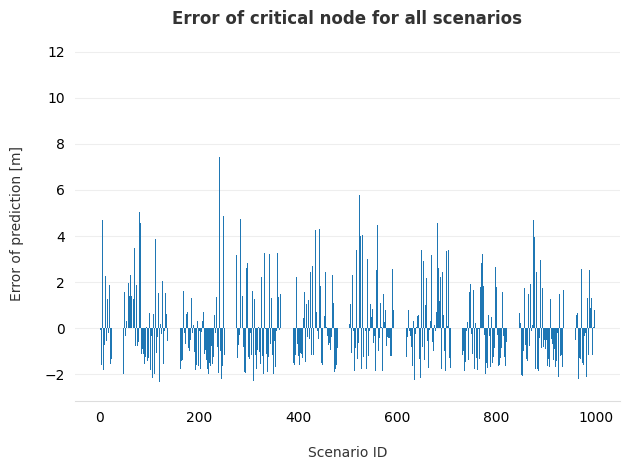

In [28]:
y_pred = NN.predict(X_test)

unnormalized_predictions = inverse_min_max_normalize(y_pred, min_target, max_target)

error = unnormalized_predictions - testing_targets
error_node = error[:, 0]
fig, ax = plt.subplots()

bars = ax.bar(
    x=np.arange(error_node.size),
    height=error_node,
)

# Axis formatting.
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['left'].set_visible(False)
ax.spines['bottom'].set_color('#DDDDDD')
ax.tick_params(bottom=False, left=False)
ax.set_axisbelow(True)
ax.yaxis.grid(True, color='#EEEEEE')
ax.xaxis.grid(False)

ax.set_xlabel('Scenario ID', labelpad=15, color='#333333')
ax.set_ylabel('Error of prediction [m]', labelpad=15, color='#333333')
ax.set_title(f'Error of critical node for all scenarios', pad=15, color='#333333', weight='bold')

fig.tight_layout()

Finally, we need to compute the RMSE for all samples in the test set to quantify our accuracy.

In [18]:
y_pred_test = NN.predict(X_test)
rmse_test = np.sqrt(np.sum((unnormalized_predictions - testing_targets).reshape(-1)**2) / y_test.shape[0])
print("RMSE on test set for best performing model: {:.4e}".format(rmse_test))

RMSE on test set for best performing model: 2.5733e+01


### Speed

We can calculate the time per scenario that the model takes.

In [30]:
start_time = time.time()
y_pred_test = NN.predict(X_test)
total_time = time.time() - start_time

num_test_sims = len(y_pred_test)

data_driven_exec_time_per_sim = total_time/num_test_sims
print(f'Data-driven model took {data_driven_exec_time_per_sim:.5f} seconds for {num_test_sims} scenarios')

Data-driven model took 0.00000 seconds for 1000 scenarios


Considering that the original model can take up to 0.04 seconds per scenario, we can estimate the potential gain in speed-up. (Speed-up = original_time/Data-driven_model_time)

In [31]:
original_time_per_sim = 0.04

speed_up = np.round(original_time_per_sim/data_driven_exec_time_per_sim, 2)
print('The data-driven model is', speed_up,'times faster than EPANET per scenario.')

The data-driven model is 8649.83 times faster than EPANET per scenario.


### 8. Save the metamodel

In [22]:
with open('model_Sklearn.p', 'wb') as handle:
    pickle.dump(NN, handle)